# Предсказание количества заказов для сервиса такси

Сервис такси собрал исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

По условию значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Ход работы

1. Загрузим данные и выполним их ресемплирование по одному часу.
2. Проанализируем данные.
3. Обучим разные модели с различными гиперпараметрами. Сделаем тестовую выборку размером 10% от исходных данных.
4. Проверим данные на тестовой выборке и сделаем выводы.

### Описание данных

Количество заказов находится в столбце '*num_orders*'.

# 1. Подготовка

In [24]:
#импортируем все необходимые библиотеки и инструменты
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

Чтобы преобразовать нужный столбец в датасете в тип данных datetime, передадим в функцию `read_csv` аргумент `parse_dates`. Индексировать данные будем по первому столбцу.

In [25]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
display(taxi.info())
taxi.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Наблюдения в датасете сделаны с разницей в 10 минут. Это слишком подробные данные. Выполним ресемплирование с интервалом в 1 час. Данные суммируем.

In [26]:
taxi.sort_index(inplace=True)
taxi = taxi.resample('1H').sum()

In [27]:
display(taxi.info())
taxi.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Данные подготовлены. Проанализируем их.

# 2. Анализ

Изучим данные - в какой промежуток времени велось наблюдение?

In [28]:
print("Начало наблюдения:", taxi.index.min())
print("Конец наблюдения:", taxi.index.max())

Начало наблюдения: 2018-03-01 00:00:00
Конец наблюдения: 2018-08-31 23:00:00


Нам предоставлены данные с марта по август (включительно) 2018 года.

Оценим данные на графике.

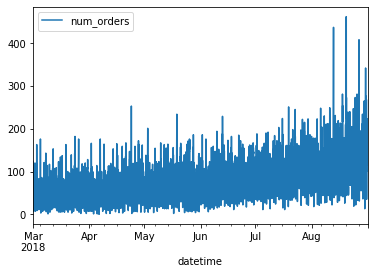

In [29]:
taxi.plot()

Мы не сможем изучить сезонность по предоставленным данным, так как информация есть только по срезу в полгода. Но можем оценить, как меняется объем заказов от первого наблюдения к последнему. Для наглядности ресемплируем данные по неделе и сохраним с новую переменную. Выведем на график.

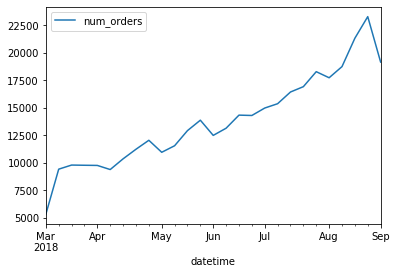

In [30]:
taxi_week = taxi.resample('1W').sum()
taxi_week.plot()

По графику можно сказать, что дела у сервиса по заказу такси идут хорошо - заказы увеличиваются от месяца к месяцу. Однако, однозначного решения принять нельзя - возможно, это стандартная практика у сервисов, и если бы мы взглянули на данные за несколько лет, то проследили бы закономерность.

С помощью функции `seasonal_decompose()` разложим временной ряд на три составляющие: тренд, сезонность и остаток (residuals) - это шум, который не объясняется трендом и сезонностью.

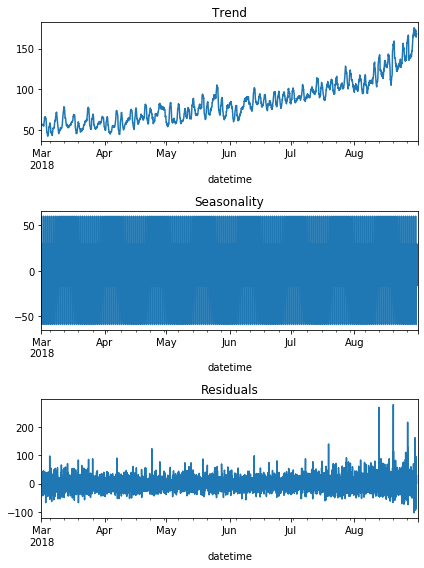

In [31]:
decomposed = seasonal_decompose(taxi['num_orders'], model='additive')

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Здесь также видно, что тренд растет от месяца к месяцу, но чтобы вывести сезонность нагляднее и изучить ее, ресемплируем данные по одному дню.

Text(0.5, 1.0, 'Seasonality')

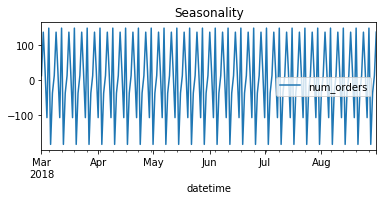

In [32]:
taxi_day = taxi.resample('1D').sum()

decomposed_day = seasonal_decompose(taxi_day)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed_day.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

Видим колебания раз в неделю - похоже, на выходных услугами такси пользуются реже. Логично - люди больше выезжают за город на личном транспорте/гуляют/остаются дома.

Найдем разности временного ряда. Станет ли он более стационарным, если применить метод `.shift()`?

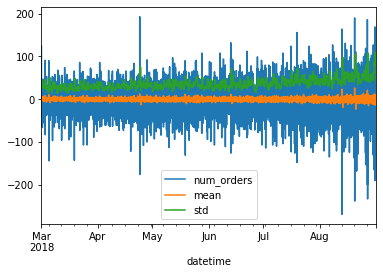

In [33]:
taxi_shifted = taxi - taxi.shift(fill_value=0)
taxi_shifted['mean'] = taxi_shifted['num_orders'].rolling(15).mean()
taxi_shifted['std'] = taxi_shifted['num_orders'].rolling(15).std()
taxi_shifted.plot()

Ряд становится более стационарным, а значит данные можно прогнозировать.

# 3. Обучение

Для успешного обучения добавим признаки в датасет. Напишем функцию `make_features()`, которая:

- добавит к датасету четыре новых календарных признака: год, месяц, день и день недели,
- вычислит и добавит отстающие значения (предыдущие значения временного ряда, которые покажут, будет ли функция x(t) расти или уменьшаться),
- вычислит скользящее среднее и добавит его как признак `rolling_mean` - этот признак задаст общий тренд временного ряда. 

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [10]:
make_features(taxi, 24, 3)
taxi.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.333333
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.000000


Разделим данные на обучающую и тестовую выборки, а затем поделим признаки.

Функция `train_test_split` по умолчанию перемешивает данные (что нам в данном случае не нужно), поэтому добавим параметр `shuffle=False`.

После применения функции `make_features` у нас появились NaN-значения за счет сдвига данных. Их никак не заполнить - просто избавимся от них.

In [11]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Проверим, что данные не перемешались - сравним последнее наблюдение признаков обучающей выборки и первое наблюдение признаков тестовой выборки.

In [12]:
print(features_train.index[features_train.shape[0]-1])
print(features_test.index[0])

2018-08-13 13:00:00
2018-08-13 14:00:00


Все верно, данные можно использовать для обучения.

In [13]:
#напишем формулу для получения значения метрики RMSE
def rmse (target, predictions):
    mse = mean_squared_error(target, predictions)
    rmse = mse ** 0.5
    return rmse

Обучим модели LinearRegression, CatBoostRegressor и LGBMRegressor.

### LinearRegression

In [14]:
lr_model = LinearRegression()
lr_model.fit(features_train, target_train)
predicted_lr = pd.Series(lr_model.predict(features_test))

### CatBoostRegressor

In [15]:
#построим модель CBR и исследуем её работу с различными значениями гиперпараметра iterations с помощью кросс-валидации
for iteration in range(75, 151, 25):
    cat_model = CatBoostRegressor(loss_function="RMSE", iterations=iteration, depth=6, verbose=10)
    cat_cv = cross_val_score(cat_model, features_train, target_train, cv=3)
    print("Score при iterations =", iteration, ":", cat_cv)
    print("Score mean =", sum(cat_cv)/len(cat_cv))
    print()

0:	learn: 38.4052844	total: 50.9ms	remaining: 3.77s
10:	learn: 34.7290112	total: 280ms	remaining: 1.63s
20:	learn: 32.0429795	total: 574ms	remaining: 1.48s
30:	learn: 30.1663531	total: 868ms	remaining: 1.23s
40:	learn: 28.8046962	total: 1.16s	remaining: 966ms
50:	learn: 27.7750352	total: 1.46s	remaining: 687ms
60:	learn: 26.9268388	total: 1.67s	remaining: 383ms
70:	learn: 26.3126876	total: 1.96s	remaining: 111ms
74:	learn: 26.1305971	total: 2.06s	remaining: 0us
0:	learn: 40.1413434	total: 3.48ms	remaining: 258ms
10:	learn: 35.4914265	total: 295ms	remaining: 1.72s
20:	learn: 32.1819122	total: 592ms	remaining: 1.52s
30:	learn: 29.8541711	total: 888ms	remaining: 1.26s
40:	learn: 28.2215743	total: 1.18s	remaining: 981ms
50:	learn: 27.0324999	total: 1.48s	remaining: 695ms
60:	learn: 26.1542907	total: 1.77s	remaining: 407ms
70:	learn: 25.4741502	total: 2.07s	remaining: 117ms
74:	learn: 25.2522795	total: 2.17s	remaining: 0us
0:	learn: 32.9362277	total: 3.46ms	remaining: 256ms
10:	learn: 29.23

In [16]:
#исследуем работу модели с различными значениями гиперпараметра depth
for depth in range(1, 10, 2):
    cat_model = CatBoostRegressor(loss_function="RMSE", iterations=150, depth=depth, verbose=10)
    cat_cv = cross_val_score(cat_model, features_train, target_train, cv=3)
    print("Score при depth =", depth, ":", cat_cv)
    print("Score mean =", sum(cat_cv)/len(cat_cv))
    print()

0:	learn: 38.5960322	total: 1.42ms	remaining: 211ms
10:	learn: 36.4271685	total: 11.3ms	remaining: 143ms
20:	learn: 34.8637504	total: 102ms	remaining: 624ms
30:	learn: 33.6615472	total: 196ms	remaining: 753ms
40:	learn: 32.6936474	total: 289ms	remaining: 769ms
50:	learn: 31.9132970	total: 382ms	remaining: 741ms
60:	learn: 31.3152216	total: 391ms	remaining: 571ms
70:	learn: 30.8210826	total: 482ms	remaining: 537ms
80:	learn: 30.3942212	total: 575ms	remaining: 489ms
90:	learn: 30.0289528	total: 581ms	remaining: 377ms
100:	learn: 29.7034727	total: 676ms	remaining: 328ms
110:	learn: 29.4148624	total: 767ms	remaining: 270ms
120:	learn: 29.1792608	total: 860ms	remaining: 206ms
130:	learn: 28.9773690	total: 868ms	remaining: 126ms
140:	learn: 28.7990108	total: 960ms	remaining: 61.3ms
149:	learn: 28.6418755	total: 1.05s	remaining: 0us
0:	learn: 40.3401494	total: 843us	remaining: 126ms
10:	learn: 37.4197360	total: 8.88ms	remaining: 112ms
20:	learn: 35.2972451	total: 20.9ms	remaining: 129ms
30:	l

На тестировании будем использовать модель CBR с гиперпараметрами iterations = 110 и depth = 7, эти гиперпараметры показали лучший результат по качеству и времени.

In [17]:
cat_model_110_7= CatBoostRegressor(loss_function="RMSE", iterations=110, depth=7, verbose=10)
cat_model_110_7.fit(features_train, target_train)
predicted_cat = pd.Series(cat_model_110_7.predict(features_test))

0:	learn: 38.1440310	total: 8.13ms	remaining: 886ms
10:	learn: 33.7661007	total: 317ms	remaining: 2.85s
20:	learn: 30.6584054	total: 807ms	remaining: 3.42s
30:	learn: 28.4600016	total: 1.21s	remaining: 3.08s
40:	learn: 26.9531198	total: 1.61s	remaining: 2.7s
50:	learn: 25.8446755	total: 2.09s	remaining: 2.42s
60:	learn: 24.9902518	total: 2.49s	remaining: 2s
70:	learn: 24.3281995	total: 2.89s	remaining: 1.59s
80:	learn: 23.7990539	total: 3.38s	remaining: 1.21s
90:	learn: 23.3627202	total: 3.77s	remaining: 788ms
100:	learn: 23.0399393	total: 4.17s	remaining: 372ms
109:	learn: 22.7875999	total: 4.56s	remaining: 0us


### LGBMRegressor

In [18]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 6, 
    'learning_rate': 0.1,
    'verbose': 0
}

In [19]:
lgbm_model = LGBMRegressor(**params)
lgbm_model.fit(features_train, target_train)
predictions_lgbm = lgbm_model.predict(features_test)

# 4. Тестирование

### LinearRegression

In [20]:
rmse(target_test, predicted_lr)

45.263458050523425

### CatBoostRegressor

In [21]:
rmse(target_test, predicted_cat)

48.43489907971826

### LGBMRegressor

In [22]:
rmse(target_test, predictions_lgbm)

41.801135657892594

**Вывод:**
Несмотря на подбор гиперпараметров для модели CBR, лучший результат показала модель LGBMRegressor со стандартными настройками. Как прототип сервису такси можно советовать её.